<a href="https://colab.research.google.com/github/fintechutcc/AI-Camp/blob/main/Thai_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# การวิเคราะห์ข้อความที่แสดงถึงอารมณ์ความรู้สึก (Sentiment Analysis)

ตัวอย่างต่อไปนี้ดัดแปลงจากผลงานของนายรักษ์พล ทองมา ในวิชาการค้นคว้าอิสระ (Independent Study) ปี 2019 หลักสูตรวิศวกรรมคอมพิวเตอร์และเทคโนโลยีการเงิน

## ขั้นตอนที่ 1: นำเข้าไลบรารีที่ต้องการใช้

In [3]:
import requests
from PIL import Image
from io import BytesIO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plot


## ขั้นตอนที่ 2: การเตรียมข้อมูล

### ลักษณะของข้อมูลเบื้องต้น

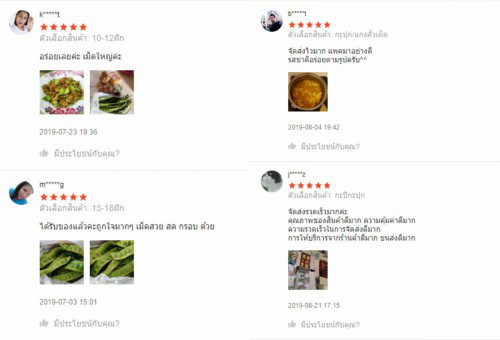

In [1]:
r_2 = requests.get('https://sv1.picz.in.th/images/2019/12/20/iHBoCP.md.jpg')
review_img = Image.open(BytesIO(r_2.content))
review_img

### ปรับข้อมูลให้อยู่ในรูปแบบที่เหมาะสม

In [4]:
all_df = pd.read_csv('https://github.com/ruxpolth/my-is/raw/master/sentiment_data_final.csv')
all_df

,Text,Type
0,Packing ปิดไม่สนิท,1
1,Size ไม่มาตรฐาน,1
2,ก้นถุงรั่วค่ะ,1
3,กรอบ เผ็ดกำลังดี ดูใหม่และสะอาด,0
4,กรอบ อร่อยมากค่ะ,0
...,...,...
995,โอเครเลยราาคาานี้ หมดแล้วจะสั่งอีกนะคะ ชอบบบบบ...,0
996,โอเคเลยครับ,0
997,เเพ้คของไม่ดี ในรูปคือซีนดูดีมาก เเต่พอได้รับ ...,1
998,เเพ็คมาน่าเกลียด,1


### สำรวจและทำความสะอาดข้อมูล

In [5]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    1000 non-null   object
 1   Type    1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


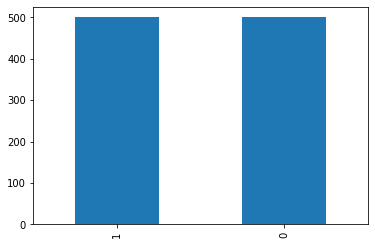

In [7]:
all_df.Type.value_counts().plot.bar()

### แบ่งข้อมูลสำหรับการ Train และ Test 

In [12]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(all_df, test_size=0.25, random_state=2022)
train_data = train_df['Text']
test_data = test_df['Text']

train_label = train_df['Type']
test_label = test_df['Type']

## ขั้นตอนที่ 3: สกัดคุณลักษณะของข้อมูล

### ติดตั้งเครื่องมือวิเคราะห์ภาษาไทย

In [9]:
%pip install pythainlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 5.5 MB/s 


ตัวอย่างการใช้งาน word_tokenize กับประโยคภาษาไทย

In [ ]:
from pythainlp import word_tokenize

message = 'มหาวิทยาลัยหอการค้าไทย เป็นสถาบันอุดมศึกษาเอกชนที่ไม่แสวงหาผลกำไร โดยมี "หอการค้าไทย" เป็นเจ้าของ และได้รับการยอมรับว่าเป็นสถาบันการศึกษาชั้นนำด้านธุรกิจในประเทศไทย ประกอบด้วย 12 คณะ'
word_tokenize(message)

In [13]:
def thai_token(text):
    text = text.lower() 
    text = text.replace('\n',' ')
    token = word_tokenize(text, engine="newmm")
    return token

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

feat_vector = CountVectorizer(tokenizer=thai_token, ngram_range=(1,2))
feat_vector.fit(train_data)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


CountVectorizer(ngram_range=(1, 2),
                tokenizer=<function thai_token at 0x7fd14eb2e950>)

In [15]:
train_feature = feat_vector.transform(train_data)
test_feature = feat_vector.transform(test_data)

In [16]:
from sklearn.preprocessing import normalize

train_feature_normalize = normalize(train_feature)
test_feature_normalize = normalize(test_feature)

## ขั้นตอนที่ 4: สร้างแบบจำลองและประเมินผล

In [17]:
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import (classification_report, make_scorer, 
                             confusion_matrix, accuracy_score, 
                             precision_score, recall_score, f1_score)

In [19]:
model_SVC = LinearSVC(random_state=2022)
model_SVC.fit(train_feature_normalize, train_label)

LinearSVC(random_state=2022)

In [20]:
c5_SVC = cross_val_score(model_SVC, train_feature_normalize, 
                         train_label, cv=5, scoring='accuracy')
mc5_SVC = cross_val_score(model_SVC, train_feature_normalize, 
                          train_label, cv=5, scoring='accuracy').mean()
print(c5_SVC)
print(mc5_SVC)

[0.89333333 0.88666667 0.90666667 0.86666667 0.91333333]
0.8933333333333333


In [21]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

c5_SVC_CV_score = cross_validate(model_SVC, train_feature_normalize, 
                                 train_label, cv=5, scoring=(scoring))
c5_SVC_CV_score

{'fit_time': array([0.00523067, 0.00564432, 0.00308442, 0.003088  , 0.00301385]),
 'score_time': array([0.01026797, 0.0029273 , 0.00290108, 0.00289154, 0.00292468]),
 'test_accuracy': array([0.89333333, 0.88666667, 0.90666667, 0.86666667, 0.91333333]),
 'test_precision': array([0.86419753, 0.8625    , 0.87654321, 0.87671233, 0.8875    ]),
 'test_recall': array([0.93333333, 0.92      , 0.94666667, 0.85333333, 0.94666667]),
 'test_f1_score': array([0.8974359 , 0.89032258, 0.91025641, 0.86486486, 0.91612903])}

In [23]:
predict_SVC = model_SVC.predict(test_feature_normalize)
result_table = pd.DataFrame()

result_table['Text'] = test_data
result_table['Type'] = test_label
result_table['SVM_Predict'] = predict_SVC

result_list = [ x==y for x,y in zip(test_label, predict_SVC)]
result_table['Predict_result'] = result_list

result_table

,Text,Type,SVM_Predict,Predict_result
652,รสชาติอร่อยดี เค็ม ๆ นิด ๆเผ็ดหน่อย ๆ กรอบดี เ...,0,0,True
579,ไม่ใช่ให้ตีคืน ส่งไปส่งมา,1,1,True
836,สินค้าตรงตามปกที่ได้ลงโฆษณาไว้,0,1,False
586,ไม่ถูกปากเราค่ะ,1,1,True
226,ชอบมากกกกกกกครับ,0,0,True
...,...,...,...,...
568,ไม่ค่อยถูกใจค่ะ,1,1,True
379,น้ำหนักไม่ไกล้เคียงที่ประกาศขาย,1,1,True
104,ของมาถึงมีมดขึ้นด้วย,1,0,False
49,กินกับชา กาแฟกำลังดีเลย,0,0,True
